3D Convolutional Neural Network

In [1]:

import h5py
import numpy as np


file_path = "full_dataset_vectors.h5"  


with h5py.File(file_path, 'r') as f:
    
    print("Available keys in the dataset:", list(f.keys()))
    
    
    point_cloud_data = f['X_train'][:]  
    
    # Extract a single data point ( the first one)
    single_point_cloud = point_cloud_data[0]
    print("Shape of a single data point:", single_point_cloud.shape)


print("Extracted single 3D point cloud data:", single_point_cloud)


Available keys in the dataset: ['X_test', 'X_train', 'y_test', 'y_train']
Shape of a single data point: (4096,)
Extracted single 3D point cloud data: [0. 0. 0. ... 0. 0. 0.]


1. 3D Convolution function:

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def conv3d_forward(input_tensor, kernel_size, stride, padding, num_filters, activation_function):
    """
    Implements a 3D convolution operation on a given input tensor.

    Args:
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, in_channels, depth, height, width).
        kernel_size (int or tuple): Size of the convolutional kernel (depth, height, width).
        stride (int or tuple): Stride for the convolution.
        padding (int or tuple): Padding added to all sides of the input.
        num_filters (int): Number of output filters.
        activation_function (str): Activation function to apply ('relu', 'sigmoid', 'tanh', 'leaky_relu').

    Returns:
        torch.Tensor: Output tensor after applying 3D convolution and activation.
    """
    # Extract input dimensions
    batch_size, in_channels, in_depth, in_height, in_width = input_tensor.shape

    # Initialize random weights and biases for the convolutional layer
    # Shape of weights: (num_filters, in_channels, kernel_depth, kernel_height, kernel_width)
    weights = torch.randn((num_filters, in_channels) + kernel_size)
    biases = torch.randn(num_filters)

    # Calculate output dimensions
    out_depth = (in_depth + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
    out_height = (in_height + 2 * padding[1] - kernel_size[1]) // stride[1] + 1
    out_width = (in_width + 2 * padding[2] - kernel_size[2]) // stride[2] + 1

    # Initialize the output tensor
    output_tensor = torch.zeros((batch_size, num_filters, out_depth, out_height, out_width))

    # Apply padding to the input tensor
    padded_input = F.pad(input_tensor, 
                         pad=(padding[2], padding[2], padding[1], padding[1], padding[0], padding[0]), 
                         mode='constant', value=0)

    # Perform the convolution operation
    for b in range(batch_size):
        for f in range(num_filters):
            for d in range(out_depth):
                for h in range(out_height):
                    for w in range(out_width):
                        # Compute the region of interest
                        d_start = d * stride[0]
                        h_start = h * stride[1]
                        w_start = w * stride[2]
                        d_end = d_start + kernel_size[0]
                        h_end = h_start + kernel_size[1]
                        w_end = w_start + kernel_size[2]

                        # Extract the local region from the padded input
                        region = padded_input[b, :, d_start:d_end, h_start:h_end, w_start:w_end]

                        # Perform element-wise multiplication and summation
                        output_tensor[b, f, d, h, w] = torch.sum(region * weights[f]) + biases[f]

    # Apply the activation function
    if activation_function == 'relu':
        output_tensor = F.relu(output_tensor)
    elif activation_function == 'sigmoid':
        output_tensor = torch.sigmoid(output_tensor)
    elif activation_function == 'tanh':
        output_tensor = torch.tanh(output_tensor)
    elif activation_function == 'leaky_relu':
        output_tensor = F.leaky_relu(output_tensor)
    else:
        raise ValueError("Unsupported activation function. Choose from 'relu', 'sigmoid', 'tanh', or 'leaky_relu'.")

    return output_tensor





Input Tensor Shape (after reshaping): torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape (after convolution): torch.Size([1, 1, 16, 16, 16])


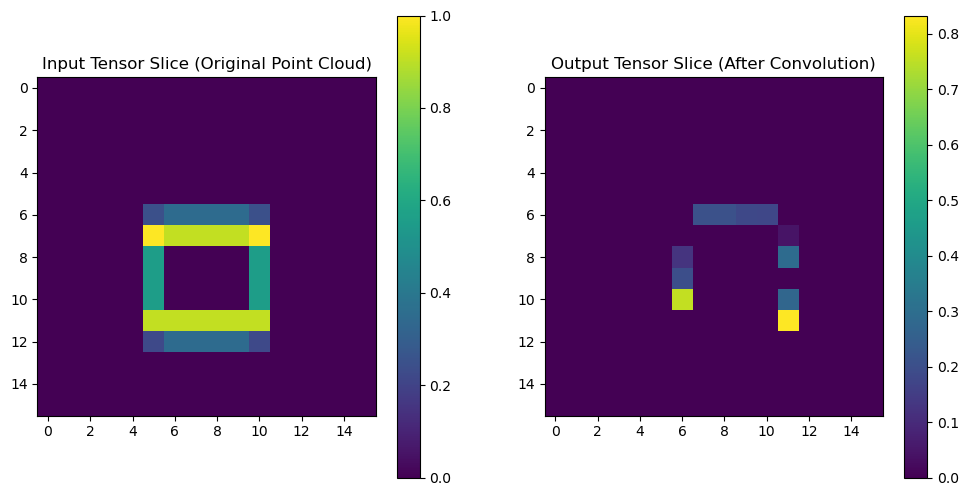

In [4]:

single_point_cloud = point_cloud_data[0]
depth, height, width = 16, 16, 16
reshaped_point_cloud = torch.tensor(single_point_cloud, dtype=torch.float32).reshape(1, 1, depth, height, width)

# Display the shape of the reshaped tensor
print("Input Tensor Shape (after reshaping):", reshaped_point_cloud.shape)
# Expected shape: (1, 1, depth=16, height=16, width=16)

# Parameters for the convolution operation
kernel_size = (3, 3, 3)  # Kernel size: Depth x Height x Width
stride = (1, 1, 1)       # Stride along each dimension
padding = (1, 1, 1)      # Padding along each dimension
num_filters = 1          # Number of filters/output channels
activation_function = 'relu'  # Activation function

# Apply the 3D convolution function on the reshaped point cloud data
output_tensor = conv3d_forward(input_tensor=reshaped_point_cloud,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               num_filters=num_filters,
                               activation_function=activation_function)

# Displaying results
print("Output Tensor Shape (after convolution):", output_tensor.shape)

# Visualizing one slice of the input and output tensors for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input Tensor Slice (Original Point Cloud)")
plt.imshow(reshaped_point_cloud[0][0][:][8].numpy(), cmap='viridis')  # Visualizing a middle slice along depth
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Output Tensor Slice (After Convolution)")
plt.imshow(output_tensor[0][0][:][8].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth
plt.colorbar()

plt.show()


2. 3D Pooling function:

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Max Pooled Tensor Shape: torch.Size([1, 1, 8, 8, 8])
Average Pooled Tensor Shape: torch.Size([1, 1, 8, 8, 8])


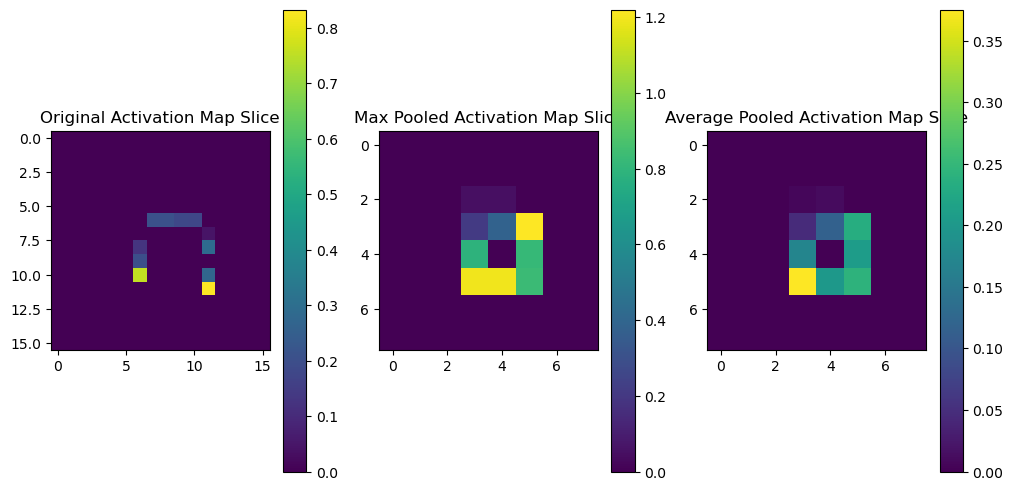

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def pooling3d(input_tensor, pool_size, stride, pooling_type='max'):
    """
    Implements 3D pooling (Max Pooling or Average Pooling) on a given activation map.

    Args:
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, channels, depth, height, width).
        pool_size (tuple): Size of the pooling window (depth, height, width).
        stride (tuple): Stride for the pooling operation (depth_stride, height_stride, width_stride).
        pooling_type (str): Type of pooling operation ('max' or 'avg').

    Returns:
        torch.Tensor: Pooled output tensor.
    """
    # Extract input dimensions
    batch_size, in_channels, in_depth, in_height, in_width = input_tensor.shape

    # Calculate output dimensions
    out_depth = (in_depth - pool_size[0]) // stride[0] + 1
    out_height = (in_height - pool_size[1]) // stride[1] + 1
    out_width = (in_width - pool_size[2]) // stride[2] + 1

    # Initialize the output tensor
    output_tensor = torch.zeros((batch_size, in_channels, out_depth, out_height, out_width))

    # Perform pooling operation
    for b in range(batch_size):
        for c in range(in_channels):
            for d in range(out_depth):
                for h in range(out_height):
                    for w in range(out_width):
                        # Define the region of interest
                        d_start = d * stride[0]
                        h_start = h * stride[1]
                        w_start = w * stride[2]
                        d_end = d_start + pool_size[0]
                        h_end = h_start + pool_size[1]
                        w_end = w_start + pool_size[2]

                        # Extract the local region from the input tensor
                        region = input_tensor[b, c, d_start:d_end, h_start:h_end, w_start:w_end]

                        # Apply pooling operation
                        if pooling_type == 'max':
                            output_tensor[b, c, d, h, w] = torch.max(region)
                        elif pooling_type == 'avg':
                            output_tensor[b, c, d, h, w] = torch.mean(region)
                        else:
                            raise ValueError("Unsupported pooling type. Use 'max' or 'avg'.")

    return output_tensor


# Example Usage
# Input tensor: Output from the previous convolution step (e.g., shape [1, 2, 16, 16, 16])
print("Input Tensor Shape:", output_tensor.shape)

# Parameters for pooling operation
pool_size = (2, 2, 2)  # Pooling window size: Depth x Height x Width
stride = (2, 2, 2)     # Stride along each dimension

# Apply Max Pooling
pooled_max = pooling3d(input_tensor=output_tensor,
                       pool_size=pool_size,
                       stride=stride,
                       pooling_type='max')

# Apply Average Pooling
pooled_avg = pooling3d(input_tensor=output_tensor,
                       pool_size=pool_size,
                       stride=stride,
                       pooling_type='avg')

# Display results
print("Max Pooled Tensor Shape:", pooled_max.shape)
print("Average Pooled Tensor Shape:", pooled_avg.shape)

# Visualize one slice of Max Pooled and Average Pooled tensors for comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Activation Map Slice")
plt.imshow(output_tensor[0][0][:][8].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Max Pooled Activation Map Slice")
plt.imshow(pooled_max[0][0][:][4].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth after max-pooling
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Average Pooled Activation Map Slice")
plt.imshow(pooled_avg[0][0][:][4].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth after avg-pooling
plt.colorbar()

plt.show()


3. 3D Convolution layer function:

Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
Output Tensor Shape: torch.Size([1, 4, 16, 16, 16])


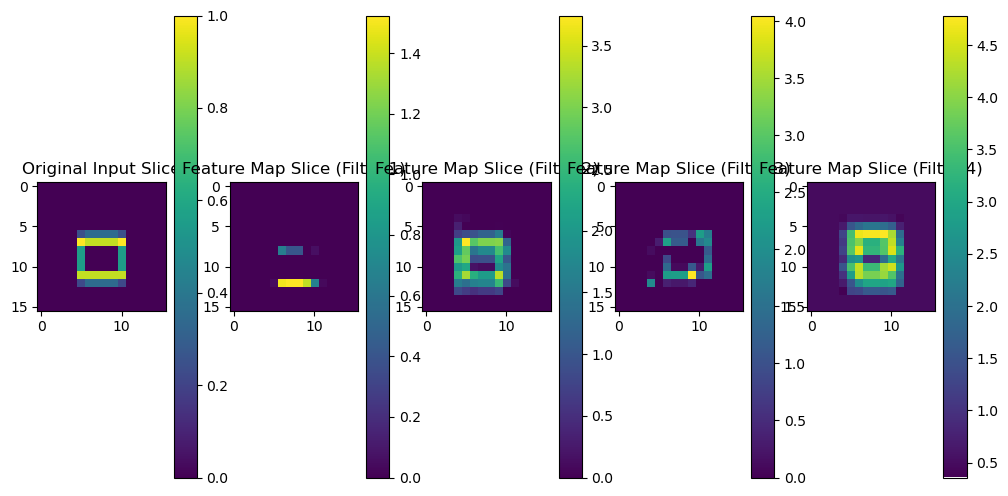

In [9]:
def conv3d_layer(input_tensor, num_filters, kernel_size, stride, padding, activation_function):
    """
    Implements a 3D convolutional layer that applies multiple 3D convolution filters.

    Args:
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, in_channels, depth, height, width).
        num_filters (int): Number of filters/output channels.
        kernel_size (tuple): Size of the convolutional kernel (depth, height, width).
        stride (tuple): Stride for the convolution.
        padding (tuple): Padding added to all sides of the input.
        activation_function (str): Activation function to apply ('relu', 'sigmoid', 'tanh', 'leaky_relu').

    Returns:
        torch.Tensor: Output tensor after applying the 3D convolutional layer.
    """
    # Extract input dimensions
    batch_size, in_channels, in_depth, in_height, in_width = input_tensor.shape

    # Initialize random weights and biases for the convolutional layer
    # Shape of weights: (num_filters, in_channels, kernel_depth, kernel_height, kernel_width)
    weights = torch.randn((num_filters, in_channels) + kernel_size)
    biases = torch.randn(num_filters)

    # Calculate output dimensions
    out_depth = (in_depth + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
    out_height = (in_height + 2 * padding[1] - kernel_size[1]) // stride[1] + 1
    out_width = (in_width + 2 * padding[2] - kernel_size[2]) // stride[2] + 1

    # Initialize the output tensor
    output_tensor = torch.zeros((batch_size, num_filters, out_depth, out_height, out_width))

    # Apply padding to the input tensor
    padded_input = F.pad(input_tensor,
                         pad=(padding[2], padding[2], padding[1], padding[1], padding[0], padding[0]),
                         mode='constant', value=0)

    # Perform the convolution operation
    for b in range(batch_size):
        for f in range(num_filters):
            for d in range(out_depth):
                for h in range(out_height):
                    for w in range(out_width):
                        # Compute the region of interest
                        d_start = d * stride[0]
                        h_start = h * stride[1]
                        w_start = w * stride[2]
                        d_end = d_start + kernel_size[0]
                        h_end = h_start + kernel_size[1]
                        w_end = w_start + kernel_size[2]

                        # Extract the local region from the padded input
                        region = padded_input[b, :, d_start:d_end, h_start:h_end, w_start:w_end]

                        # Perform element-wise multiplication and summation
                        output_tensor[b, f, d, h, w] = torch.sum(region * weights[f]) + biases[f]

    # Apply the activation function
    if activation_function == 'relu':
        output_tensor = F.relu(output_tensor)
    elif activation_function == 'sigmoid':
        output_tensor = torch.sigmoid(output_tensor)
    elif activation_function == 'tanh':
        output_tensor = torch.tanh(output_tensor)
    elif activation_function == 'leaky_relu':
        output_tensor = F.leaky_relu(output_tensor)
    else:
        raise ValueError("Unsupported activation function. Choose from 'relu', 'sigmoid', 'tanh', or 'leaky_relu'.")

    return output_tensor


# Example Usage
# Assuming `reshaped_point_cloud` from earlier steps is the input to this layer
# Parameters for the convolutional layer
num_filters = 4          # Number of filters/output channels
kernel_size = (3, 3, 3)  # Kernel size: Depth x Height x Width
stride = (1, 1, 1)       # Stride along each dimension
padding = (1, 1, 1)      # Padding along each dimension
activation_function = 'relu'  # Activation function

# Apply the 3D convolutional layer function on the reshaped point cloud data
conv_layer_output = conv3d_layer(input_tensor=reshaped_point_cloud,
                                 num_filters=num_filters,
                                 kernel_size=kernel_size,
                                 stride=stride,
                                 padding=padding,
                                 activation_function=activation_function)

# Display results
print("Input Tensor Shape:", reshaped_point_cloud.shape)
print("Output Tensor Shape:", conv_layer_output.shape)

# Visualize one slice of a filter's feature map for comparison
plt.figure(figsize=(12, 6))

# Original feature map slice visualization
plt.subplot(1, num_filters+1, 1)
plt.title("Original Input Slice")
plt.imshow(reshaped_point_cloud[0][0][:][8].numpy(), cmap='viridis')  # Visualizing a middle slice along depth
plt.colorbar()

# Visualize feature maps from each filter after convolution
for f in range(num_filters):
    plt.subplot(1, num_filters+1, f+2)
    plt.title(f"Feature Map Slice (Filter {f+1})")
    plt.imshow(conv_layer_output[0][f][:][8].detach().numpy(), cmap='viridis')  # Middle slice along depth for filter f
    plt.colorbar()

plt.show()


4. 3D Pooling layer function:

Input Tensor Shape: torch.Size([1, 4, 16, 16, 16])
Local Max Pooled Tensor Shape: torch.Size([1, 4, 8, 8, 8])
Local Average Pooled Tensor Shape: torch.Size([1, 4, 8, 8, 8])
Global Average Pooled Tensor Shape: torch.Size([1, 4, 1, 1, 1])


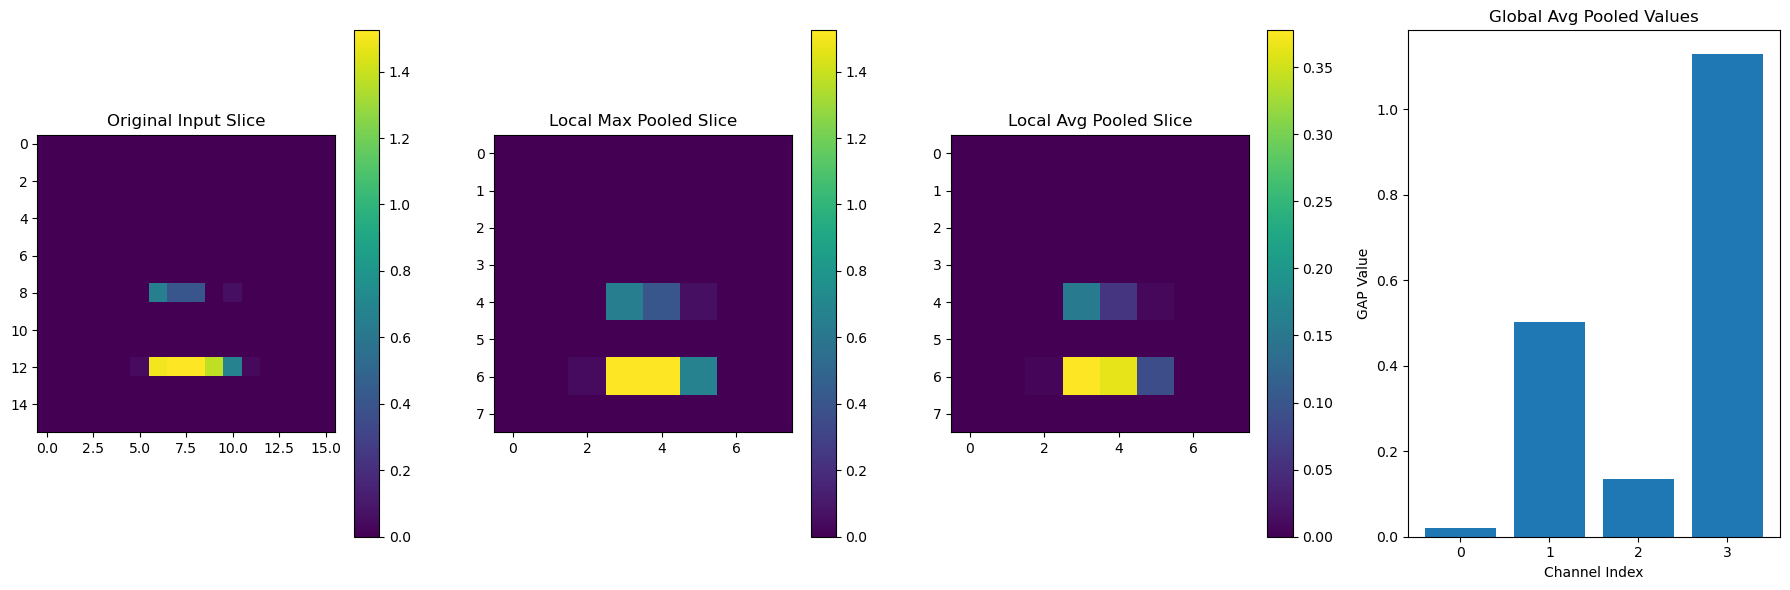

In [17]:
def pooling3d_layer(input_tensor, pool_size=None, stride=None, pooling_type='max', global_pooling=False):
    """
    Implements a 3D pooling layer that supports both local pooling and Global Average Pooling (GAP).

    Args:
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, channels, depth, height, width).
        pool_size (tuple): Size of the pooling window (depth, height, width) for local pooling.
        stride (tuple): Stride for the pooling operation (depth_stride, height_stride, width_stride).
        pooling_type (str): Type of pooling operation ('max' or 'avg').
        global_pooling (bool): If True, performs Global Average Pooling (GAP).

    Returns:
        torch.Tensor: Pooled output tensor.
    """
    if global_pooling:
        # Perform Global Average Pooling
        return torch.mean(input_tensor, dim=(2, 3, 4), keepdim=True)

    # Extract input dimensions
    batch_size, channels, in_depth, in_height, in_width = input_tensor.shape

    # Calculate output dimensions for local pooling
    out_depth = (in_depth - pool_size[0]) // stride[0] + 1
    out_height = (in_height - pool_size[1]) // stride[1] + 1
    out_width = (in_width - pool_size[2]) // stride[2] + 1

    # Initialize the output tensor
    output_tensor = torch.zeros((batch_size, channels, out_depth, out_height, out_width))

    # Perform local pooling operation
    for b in range(batch_size):
        for c in range(channels):
            for d in range(out_depth):
                for h in range(out_height):
                    for w in range(out_width):
                        # Define the region of interest
                        d_start = d * stride[0]
                        h_start = h * stride[1]
                        w_start = w * stride[2]
                        d_end = d_start + pool_size[0]
                        h_end = h_start + pool_size[1]
                        w_end = w_start + pool_size[2]

                        # Extract the local region from the input tensor
                        region = input_tensor[b, c, d_start:d_end, h_start:h_end, w_start:w_end]

                        # Apply pooling operation
                        if pooling_type == 'max':
                            output_tensor[b, c, d, h, w] = torch.max(region)
                        elif pooling_type == 'avg':
                            output_tensor[b, c, d, h, w] = torch.mean(region)
                        else:
                            raise ValueError("Unsupported pooling type. Use 'max' or 'avg'.")

    return output_tensor


# Example Usage
# Assuming `conv_layer_output` from the previous step is the input to this layer
print("Input Tensor Shape:", conv_layer_output.shape)

# Parameters for local pooling
pool_size = (2, 2, 2)  # Pooling window size: Depth x Height x Width
stride = (2, 2, 2)     # Stride along each dimension

# Apply Max Pooling
pooled_max_local = pooling3d_layer(input_tensor=conv_layer_output,
                                   pool_size=pool_size,
                                   stride=stride,
                                   pooling_type='max',
                                   global_pooling=False)

# Apply Average Pooling
pooled_avg_local = pooling3d_layer(input_tensor=conv_layer_output,
                                   pool_size=pool_size,
                                   stride=stride,
                                   pooling_type='avg',
                                   global_pooling=False)

# Apply Global Average Pooling (GAP)
pooled_gap = pooling3d_layer(input_tensor=conv_layer_output,
                             global_pooling=True)

# Display results
print("Local Max Pooled Tensor Shape:", pooled_max_local.shape)
print("Local Average Pooled Tensor Shape:", pooled_avg_local.shape)
print("Global Average Pooled Tensor Shape:", pooled_gap.shape)

# Visualize one slice of Local Max Pooled and Local Avg Pooled tensors for comparison
plt.figure(figsize=(18, 6))

# Original feature map slice visualization
plt.subplot(1, 4, 1)
plt.title("Original Input Slice")
plt.imshow(conv_layer_output[0][0][:][8].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth
plt.colorbar()

# Max Pooled feature map slice visualization
plt.subplot(1, 4, 2)
plt.title("Local Max Pooled Slice")
plt.imshow(pooled_max_local[0][0][:][4].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth after max-pooling
plt.colorbar()

# Avg Pooled feature map slice visualization
plt.subplot(1, 4, 3)
plt.title("Local Avg Pooled Slice")
plt.imshow(pooled_avg_local[0][0][:][4].detach().numpy(), cmap='viridis')  # Visualizing a middle slice along depth after avg-pooling
plt.colorbar()

plt.subplot(1, 4, 4)
plt.title("Global Avg Pooled Values")
gap_values = pooled_gap[0].squeeze().detach().numpy()  # Squeeze to remove singleton dimensions
plt.bar(range(len(gap_values)), gap_values)  # Visualize GAP values as a bar chart
plt.xlabel("Channel Index")
plt.ylabel("GAP Value")

plt.tight_layout()
plt.show()

5. Multilayer Perceptron (MLP) function:

In [46]:
import math

def initialize_weights(input_size, output_size):
    """
    Initializes weights and biases for a layer using Xavier initialization.
    Args:
        input_size (int): Number of input neurons.
        output_size (int): Number of output neurons.
    Returns:
        weights (torch.Tensor): Weight matrix of shape (output_size, input_size).
        biases (torch.Tensor): Bias vector of shape (output_size,).
    """
    limit = math.sqrt(6 / (input_size + output_size))
    weights = torch.randn(output_size, input_size) * limit
    biases = torch.zeros(output_size)
    return weights, biases


def activation_function(x, activation_type):
    """
    Applies an activation function to the input.
    Args:
        x (torch.Tensor): Input tensor.
        activation_type (str): Type of activation ('relu', 'sigmoid', 'tanh', 'leaky_relu').
    Returns:
        torch.Tensor: Activated output tensor.
    """
    if activation_type == 'relu':
        return torch.maximum(x, torch.tensor(0.0))
    elif activation_type == 'sigmoid':
        return 1 / (1 + torch.exp(-x))
    elif activation_type == 'tanh':
        return torch.tanh(x)
    elif activation_type == 'leaky_relu':
        return torch.where(x > 0, x, 0.01 * x)
    else:
        raise ValueError("Unsupported activation type. Choose from 'relu', 'sigmoid', 'tanh', or 'leaky_relu'.")


def softmax(x):
    """
    Applies the softmax function to the input tensor.
    Args:
        x (torch.Tensor): Input tensor.
    Returns:
        torch.Tensor: Softmax probabilities.
    """
    exp_x = torch.exp(x - x.max())  # Subtract max for numerical stability
    return exp_x / exp_x.sum()




In [48]:
def mlp_classifier(flattened_input, layer_sizes, hidden_activation='relu'):
    """
    Implements an MLP classifier with one hidden layer and softmax output.

    Args:
        flattened_input (torch.Tensor): Input tensor after flattening (from GAP).
        layer_sizes (list): List containing sizes of input layer, hidden layer(s), and output layer.
        hidden_activation (str): Activation function for hidden layers ('relu').

    Returns:
        torch.Tensor: Output tensor after softmax activation.
    """
    # Extract sizes
    input_size = layer_sizes[0]
    hidden_size = layer_sizes[1]
    output_size = layer_sizes[2]

    # Initialize weights and biases for hidden layer
    hidden_weights = torch.randn(hidden_size, input_size) * 0.01
    hidden_biases = torch.zeros(hidden_size)
    
    # Compute hidden layer output
    hidden_output = torch.matmul(hidden_weights, flattened_input) + hidden_biases

    # Apply activation function to hidden layer
    if hidden_activation == 'relu':
        hidden_output = torch.maximum(hidden_output, torch.tensor(0))  # ReLU activation
    else:
        raise ValueError("Unsupported activation function for hidden layers.")

    # Initialize weights and biases for output layer
    output_weights = torch.randn(output_size, hidden_size) * 0.01
    output_biases = torch.zeros(output_size)

    # Compute logits for output layer
    logits = torch.matmul(output_weights, hidden_output) + output_biases

    # Apply softmax activation to logits
    exp_logits = torch.exp(logits - torch.max(logits))  # Subtract max(logits) for numerical stability
    probs = exp_logits / torch.sum(exp_logits)

    return probs


# Example Usage for Q5
# Flattened input from GAP (should have size 32)
flattened_gap_output = torch.randn(32)  # Replace with actual flattened GAP output

# Define MLP architecture
layer_sizes = [32, 64, 10]  # Input size: 32 (from GAP), Hidden size: 64, Output size: 10

# Pass through MLP classifier
output_probs = mlp_classifier(flattened_gap_output, layer_sizes=layer_sizes)

# Display results
print("Input Vector Shape:", flattened_gap_output.shape)
print("Output Probabilities Shape:", output_probs.shape)
print("Output Probabilities:", output_probs)


Input Vector Shape: torch.Size([32])
Output Probabilities Shape: torch.Size([10])
Output Probabilities: tensor([0.1004, 0.1001, 0.0997, 0.1001, 0.0994, 0.1004, 0.1004, 0.0999, 0.0998,
        0.0998])


6. Putting-it all together:

In [51]:
def forward_pass_3d_cnn(input_tensor):
    """
    Implements the forward pass of the complete 3D CNN model.

    Args:
        input_tensor (torch.Tensor): Input tensor of shape (batch_size, channels, depth, height, width).

    Returns:
        torch.Tensor: Output tensor of shape (10,) representing class probabilities.
    """
    # Layer 1: 3D Convolution Layer with 16 filters of size 5x5x5 and ReLU activation
    conv1 = conv3d_layer(input_tensor=input_tensor,
                         num_filters=16,
                         kernel_size=(5, 5, 5),
                         stride=(1, 1, 1),
                         padding=(2, 2, 2),  # Same padding to keep dimensions
                         activation_function='relu')
    print("After Conv1:", conv1.shape)

    

    # Layer 2: Max Pooling Layer with size 2x2x2 and stride 2
    pool1 = pooling3d_layer(input_tensor=conv1,
                            pool_size = (2, 2, 2),
                            
                            stride=(2, 2, 2),
                            pooling_type='max',
                            global_pooling=False)
    print("After Pool1:", pool1.shape)

    # Layer 3: 3D Convolution Layer with 32 filters of size 3x3x3 and ReLU activation
    conv2 = conv3d_layer(input_tensor=pool1,
                         num_filters=32,
                         kernel_size=(3, 3, 3),
                         stride=(1, 1, 1),
                         padding=(1, 1, 1),  # Same padding to keep dimensions
                         activation_function='relu')
    print("After Conv2:", conv2.shape)

    # Layer 4: Max Pooling Layer with size 2x2x2 and stride 2
    pool2 = pooling3d_layer(input_tensor=conv2,
                            pool_size = (2, 2, 2),
                            
                            stride=(2, 2, 2),
                            pooling_type='max',
                            global_pooling=False)
    print("After Pool2:", pool2.shape)

    # Layer 5: Global Average Pooling (GAP) Layer
    gap = pooling3d_layer(input_tensor=pool2,
                          pooling_type=None,
                          global_pooling=True)
    print("After GAP:", gap.shape)

    # Flatten GAP output for MLP input
    flattened_gap = gap.view(-1)  # Shape: (num_filters,)
    print("Flattened GAP Shape:", flattened_gap.shape)

    # Layer 6: MLP Classifier
    # Define MLP architecture
    input_size = flattened_gap.shape[0]   # Number of input neurons from GAP output
    hidden_layer_size = 64                # Number of neurons in the hidden layer
    output_size = 10                      # Number of output classes for MNIST digits

    layer_sizes = [input_size, hidden_layer_size, output_size]

    # Pass through MLP
    output_probs = mlp_classifier(flattened_gap,
                                  layer_sizes=layer_sizes,
                                  hidden_activation='relu')
    
    return output_probs


# Example Usage
# Assuming `reshaped_point_cloud` is the input tensor from earlier steps
# Input tensor shape: (batch_size=1, channels=1, depth=16, height=16, width=16)

print("Input Tensor Shape:", reshaped_point_cloud.shape)

# Perform forward pass through the entire model
final_output_probs = forward_pass_3d_cnn(reshaped_point_cloud)

# Display final results
print("Final Output Probabilities Shape:", final_output_probs.shape)
print("Final Output Probabilities:", final_output_probs)


Input Tensor Shape: torch.Size([1, 1, 16, 16, 16])
After Conv1: torch.Size([1, 16, 16, 16, 16])
After Pool1: torch.Size([1, 16, 8, 8, 8])
After Conv2: torch.Size([1, 32, 8, 8, 8])
After Pool2: torch.Size([1, 32, 4, 4, 4])
After GAP: torch.Size([1, 32, 1, 1, 1])
Flattened GAP Shape: torch.Size([32])
Final Output Probabilities Shape: torch.Size([10])
Final Output Probabilities: tensor([0.0854, 0.0927, 0.1090, 0.0979, 0.1087, 0.1130, 0.0985, 0.1026, 0.0948,
        0.0974])


Sequence Models
Generating and Saving the Dataset

In [2]:
import random
import csv
import string

# Define bracket pairs
bracket_pairs = {"(": ")", "{": "}", "[": "]", "<": ">"}
open_brackets = set(bracket_pairs.keys())
close_brackets = set(bracket_pairs.values())

# Define characters allowed in the sequences
allowed_chars = string.ascii_letters + string.digits + string.punctuation + " "

def generate_random_sequence(length):
    """
    Generates a random sequence with a mix of brackets and other characters.
    """
    sequence = []
    stack = []  # To track balanced pairs

    for _ in range(length):
        choice = random.random()
        if choice < 0.2 and stack:  # 20% chance to close a bracket if possible
            sequence.append(bracket_pairs[stack.pop()])
        elif choice < 0.3:  # 10% chance to open a new bracket
            bracket = random.choice(list(open_brackets))
            sequence.append(bracket)
            stack.append(bracket)
        else:  # 70% chance to add random characters
            sequence.append(random.choice(allowed_chars))
    
    # Ensure all opened brackets are closed
    while stack:
        sequence.append(bracket_pairs[stack.pop()])
    
    return "".join(sequence)

def count_balanced_brackets(sequence):
    """
    Counts fully balanced bracket pairs using a stack-based approach.
    """
    stack = []
    balanced_count = 0

    for char in sequence:
        if char in open_brackets:
            stack.append(char)
        elif char in close_brackets:
            if stack and bracket_pairs[stack[-1]] == char:
                stack.pop()
                balanced_count += 1  # Count a fully matched pair

    return balanced_count

# Generate dataset
num_samples = 5000
min_length, max_length = 10, 100

dataset = []
for _ in range(num_samples):
    seq_length = random.randint(min_length, max_length)
    sequence = generate_random_sequence(seq_length)
    balanced_count = count_balanced_brackets(sequence)
    dataset.append((sequence, balanced_count))

# Save dataset to CSV
csv_file_path = "balanced_brackets_dataset.csv"

with open(csv_file_path, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["sequence", "balanced_count"])  # Header
    writer.writerows(dataset)

print(f"Dataset saved to {csv_file_path} with {len(dataset)} samples.")

Dataset saved to balanced_brackets_dataset.csv with 5000 samples.


Step 1: Preprocessing the Dataset

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import string

# Load dataset
df = pd.read_csv("balanced_brackets_dataset.csv")

# Create a character-level vocabulary
allowed_chars = string.ascii_letters + string.digits + string.punctuation + " "
char_to_index = {char: idx + 1 for idx, char in enumerate(allowed_chars)}
char_to_index["<PAD>"] = 0  # Padding token

# Encode text sequences
def encode_sequence(seq, max_length=100):
    encoded = [char_to_index.get(c, 0) for c in seq]  # Convert characters to indices
    if len(encoded) < max_length:
        encoded += [0] * (max_length - len(encoded))  # Padding
    return encoded[:max_length]

# Prepare dataset
df["encoded_sequence"] = df["sequence"].apply(lambda x: encode_sequence(x))

# Convert to PyTorch dataset
class BracketDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data["encoded_sequence"].tolist(), dtype=torch.long)
        self.targets = torch.tensor(data["balanced_count"].values, dtype=torch.float32)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

# Create train & test sets
dataset = BracketDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Step 2: Baseline Model (Always Predicts 1)

In [68]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()

    def forward(self, x):
        return torch.ones(x.shape[0], 1)  # Always predicts 1

# Evaluate baseline
def evaluate_baseline():
    model = BaselineModel()
    mse_loss = nn.MSELoss()
    total_loss = 0
    count = 0

    for inputs, targets in test_loader:
        preds = model(inputs)
        loss = mse_loss(preds.squeeze(), targets)
        total_loss += loss.item()
        count += 1

    print(f"Baseline MSE Loss: {total_loss / count:.4f}")

evaluate_baseline()

Baseline MSE Loss: 67.8594


Step 3: Elmon Network (Simple RNN)

In [71]:
class ElmonRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(ElmonRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_xh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_hy = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_length = x.shape
        h_t = torch.zeros(batch_size, self.hidden_size)

        x_embed = self.embedding(x)
        for t in range(seq_length):
            h_t = torch.tanh(torch.matmul(x_embed[:, t, :], self.W_xh) + torch.matmul(h_t, self.W_hh))

        output = self.W_hy(h_t)
        return output.squeeze()

# Train Elmon Network
def train_model(model, epochs=10, lr=0.001):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss / len(train_loader))
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

    return losses

# Initialize and train Elmon RNN
elmon_model = ElmonRNN(vocab_size=len(char_to_index), hidden_size=128)
elmon_losses = train_model(elmon_model)

Epoch 1, Loss: 26.7402
Epoch 2, Loss: 17.7094
Epoch 3, Loss: 17.3881
Epoch 4, Loss: 17.2780
Epoch 5, Loss: 17.2303
Epoch 6, Loss: 17.1291
Epoch 7, Loss: 16.9795
Epoch 8, Loss: 16.8961
Epoch 9, Loss: 16.9083
Epoch 10, Loss: 16.8225


Step 4: LSTM (Manually Implemented)

In [74]:
class LSTMCustom(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(LSTMCustom, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.W_xf = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_hf = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_xi = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_hi = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_xo = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_ho = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_hy = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size, seq_length = x.shape
        h_t = torch.zeros(batch_size, self.hidden_size)
        c_t = torch.zeros(batch_size, self.hidden_size)

        x_embed = self.embedding(x)
        for t in range(seq_length):
            f_t = torch.sigmoid(torch.matmul(x_embed[:, t, :], self.W_xf) + torch.matmul(h_t, self.W_hf))
            i_t = torch.sigmoid(torch.matmul(x_embed[:, t, :], self.W_xi) + torch.matmul(h_t, self.W_hi))
            o_t = torch.sigmoid(torch.matmul(x_embed[:, t, :], self.W_xo) + torch.matmul(h_t, self.W_ho))
            c_t = f_t * c_t + i_t * torch.tanh(torch.matmul(x_embed[:, t, :], self.W_xi))
            h_t = o_t * torch.tanh(c_t)

        output = self.W_hy(h_t)
        return output.squeeze()

# Train LSTM
lstm_model = LSTMCustom(vocab_size=len(char_to_index), hidden_size=128)
lstm_losses = train_model(lstm_model)

Epoch 1, Loss: 31.8783
Epoch 2, Loss: 16.9839
Epoch 3, Loss: 9.5554
Epoch 4, Loss: 5.5164
Epoch 5, Loss: 4.0300
Epoch 6, Loss: 3.4555
Epoch 7, Loss: 3.0776
Epoch 8, Loss: 2.8026
Epoch 9, Loss: 2.6352
Epoch 10, Loss: 2.6728


Step 5: GRU (Manually Implemented)

In [77]:
class GRUCustom(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(GRUCustom, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.W_xz = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)  # Update gate
        self.W_hz = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_xr = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)  # Reset gate
        self.W_hr = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.W_xh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)  # Candidate hidden state
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)

        self.W_hy = nn.Linear(hidden_size, 1)  # Output layer

    def forward(self, x):
        batch_size, seq_length = x.shape
        h_t = torch.zeros(batch_size, self.hidden_size)

        x_embed = self.embedding(x)
        for t in range(seq_length):
            z_t = torch.sigmoid(torch.matmul(x_embed[:, t, :], self.W_xz) + torch.matmul(h_t, self.W_hz))  # Update gate
            r_t = torch.sigmoid(torch.matmul(x_embed[:, t, :], self.W_xr) + torch.matmul(h_t, self.W_hr))  # Reset gate
            h_tilde = torch.tanh(torch.matmul(x_embed[:, t, :], self.W_xh) + torch.matmul(r_t * h_t, self.W_hh))  # Candidate state
            h_t = (1 - z_t) * h_t + z_t * h_tilde  # Final hidden state

        output = self.W_hy(h_t)
        return output.squeeze()

# Train GRU
gru_model = GRUCustom(vocab_size=len(char_to_index), hidden_size=128)
gru_losses = train_model(gru_model)

Epoch 1, Loss: 25.6978
Epoch 2, Loss: 16.0190
Epoch 3, Loss: 13.4825
Epoch 4, Loss: 10.2908
Epoch 5, Loss: 7.8708
Epoch 6, Loss: 6.0205
Epoch 7, Loss: 4.8457
Epoch 8, Loss: 3.8809
Epoch 9, Loss: 2.9417
Epoch 10, Loss: 2.3858


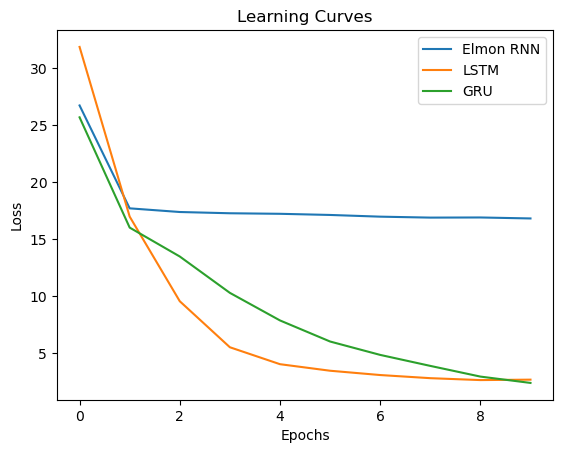

In [79]:
plt.plot(elmon_losses, label="Elmon RNN")
plt.plot(lstm_losses, label="LSTM")
plt.plot(gru_losses, label="GRU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curves")
plt.show()

In [81]:
def evaluate_model(model, test_loader, num_samples=5):
    """
    Evaluates the model on test data and prints sample predictions.
    """
    model.eval()
    mse_loss = nn.MSELoss()
    total_loss = 0
    count = 0
    sample_results = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            preds = model(inputs)
            loss = mse_loss(preds.squeeze(), targets)
            total_loss += loss.item()
            count += 1

            # Store a few sample results
            for i in range(min(num_samples, len(inputs))):
                sample_results.append((inputs[i], targets[i].item(), preds[i].item()))

    avg_loss = total_loss / count
    return avg_loss, sample_results

# Evaluate all models
elmon_loss, elmon_samples = evaluate_model(elmon_model, test_loader)
lstm_loss, lstm_samples = evaluate_model(lstm_model, test_loader)
gru_loss, gru_samples = evaluate_model(gru_model, test_loader)

# Print losses
print(f"Elmon RNN Test MSE Loss: {elmon_loss:.4f}")
print(f"LSTM Test MSE Loss: {lstm_loss:.4f}")
print(f"GRU Test MSE Loss: {gru_loss:.4f}")

Elmon RNN Test MSE Loss: 17.4045
LSTM Test MSE Loss: 3.1346
GRU Test MSE Loss: 2.7878


In [83]:
def decode_sequence(encoded_seq):
    """
    Converts a numerical sequence back to its original text representation.
    Removes <PAD> tokens from the output.
    """
    index_to_char = {v: k for k, v in char_to_index.items()}
    decoded = "".join(index_to_char.get(idx, "?") for idx in encoded_seq.tolist())
    return decoded.replace("<PAD>", "").strip()  # Remove <PAD> tokens
# Display 5 sample predictions for each model
print("\nSample Test Results:")

def print_samples(model_name, samples):
    print(f"\n--- {model_name} Predictions ---")
    for seq, true_count, pred_count in samples:
        print(f"Sequence: {decode_sequence(seq)}")
        print(f"Actual Balanced Count: {true_count}, Predicted: {pred_count:.2f}")
        print("-" * 50)

print_samples("Elmon RNN", elmon_samples)
print_samples("LSTM", lstm_samples)
print_samples("GRU", gru_samples)


Sample Test Results:

--- Elmon RNN Predictions ---
Sequence: &)M]Q({K)gr1<>pb[{+}]9<n/%()FTb]p{}BK>6[:W{}{}]
Actual Balanced Count: 9.0, Predicted: 8.17
--------------------------------------------------
Sequence: C<v><>O(O)CD[]u[]-%[]X[](GpFlf<>)f
Actual Balanced Count: 9.0, Predicted: 8.17
--------------------------------------------------
Sequence: |(GO~<<[>nx[Kh]#>Dgi<,F(D^)>
Actual Balanced Count: 3.0, Predicted: 8.17
--------------------------------------------------
Sequence: 4H6<o!{="}><(3ve@9[kQ]Z(ve[K[n]]e)%<u|?t[fh4)4(*hv/21p'y)I2'sB<<zBW;R>C/>
Actual Balanced Count: 9.0, Predicted: 8.17
--------------------------------------------------
Sequence: (<h>Fv{#){{}g`DH}1( )g}{}('/hiG)f(n)f[Q.b{d%[p8&o}J(a6Dr*l,'f)]
Actual Balanced Count: 10.0, Predicted: 8.17
--------------------------------------------------
Sequence: N![/4{]~guI{}(9Ppl)<M#<>c<Y>(Tr1)2>IlO:R4(Uhol<A>)
Actual Balanced Count: 8.0, Predicted: 8.17
--------------------------------------------------
Sequence: aFBC_